# CCA2 - Binary Classification with Weighted BPR

## Strategy (Improved from cca2)
- **Ground Truth**: All user-item interactions are positive (rating ignored for classification)
- **Task**: Predict whether a user-item pair will have an interaction
- **Graph**: Unweighted bipartite graph
- **Model**: LightGCN (EMB_DIM=32, N_LAYERS=2)
- **Loss**: **Weighted BPR Loss** (NEW!) + User Bias Calibration (NEW!)
  - Higher rating edges get higher loss weight
  - User bias removed for fair comparison
- **Evaluation**: AUC-ROC, F1, Precision, Recall
- **Recommendation**: Hybrid (Threshold + Top-K)

## Key Improvements from cca2:
- ✅ **Rating as loss weight** (not prediction target)
- ✅ Higher quality interactions (rating 5) get more attention
- ✅ Lower quality interactions (rating 1) get less attention
- ✅ User bias calibration for fair weighting
- ✅ Still binary classification (not regression)

## Expected Performance:
- AUC-ROC: **0.91+** (vs cca2 0.889)
- F1: **0.86+** (vs cca2 0.845)
- Better quality-aware recommendations without losing simplicity

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import time

import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device setup (CUDA > MPS > CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Device: {device} ({torch.cuda.get_device_name()})')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f'Device: {device}')
else:
    device = torch.device('cpu')
    print(f'Device: {device}')

Device: mps


## 1. Data Preprocessing

### A ver Strategy:
- Treat ALL interactions as positive (rating value ignored)
- Any user-item connection = positive edge
- No rating-based filtering

In [2]:
df = pd.read_csv('../data/train.csv')

print(f"Total interactions: {len(df):,}")
print(f"Unique users: {df['user'].nunique()}")
print(f"Unique items: {df['item'].nunique()}")
print(f"\nRating distribution (for reference, not used in A ver):")
print(df['rating'].value_counts().sort_index())

# ID mapping
user2idx = {u: i for i, u in enumerate(sorted(df['user'].unique()))}
item2idx = {it: i for i, it in enumerate(sorted(df['item'].unique()))}
idx2user = {i: u for u, i in user2idx.items()}
idx2item = {i: it for it, i in item2idx.items()}

n_users, n_items = len(user2idx), len(item2idx)

df['user_idx'] = df['user'].map(user2idx)
df['item_idx'] = df['item'].map(item2idx)

print(f"\nUsers: {n_users}, Items: {n_items}")
print(f"Sparsity: {(1 - len(df) / (n_users * n_items)) * 100:.4f}%")

Total interactions: 105,139
Unique users: 668
Unique items: 10321

Rating distribution (for reference, not used in A ver):
rating
0.5     1189
1.0     3254
1.5     1564
2.0     7929
2.5     5473
3.0    21676
3.5    12224
4.0    28831
4.5     8174
5.0    14825
Name: count, dtype: int64

Users: 668, Items: 10321
Sparsity: 98.4750%


In [3]:
# User별 interaction count 및 K값 계산
user_interaction_count = df.groupby('user_idx').size().to_dict()

MAX_K = 100  # K 상한선

def get_k_for_user(count):
    """User별 추천 개수 K 계산 (평가 규칙: 20% 이하 추천)"""
    if count <= 10:
        return 2  # Cold user: 무조건 2개
    k = max(2, int(count * 0.2))
    return min(k, MAX_K)

user_k = {u: get_k_for_user(c) for u, c in user_interaction_count.items()}

# 통계
k_values = list(user_k.values())
print(f"User K values statistics (MAX_K={MAX_K}):")
print(f"  Min K: {min(k_values)}")
print(f"  Max K: {max(k_values)}")
print(f"  Mean K: {np.mean(k_values):.2f}")
print(f"  Median K: {np.median(k_values):.2f}")

cold_users = sum(1 for c in user_interaction_count.values() if c <= 10)
print(f"\nCold users (≤10 interactions): {cold_users} ({100*cold_users/n_users:.1f}%)")

User K values statistics (MAX_K=100):
  Min K: 4
  Max K: 100
  Mean K: 24.74
  Median K: 14.00

Cold users (≤10 interactions): 0 (0.0%)


## 2. Train/Val/Test Split

### A ver Split:
- ALL edges are split into train/val/test (7:1.5:1.5)
- No rating-based filtering
- User-wise split to ensure each user has data in all sets

In [4]:
# Train/Val/Test Split (70/15/15) - User-wise
train_data, val_data, test_data = [], [], []

for user_idx in range(n_users):
    user_df = df[df['user_idx'] == user_idx][['user_idx', 'item_idx']]
    n_interactions = len(user_df)
    
    if n_interactions >= 3:
        user_df = user_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
        train_end = int(0.7 * n_interactions)
        val_end = train_end + int(0.15 * n_interactions)
        
        train_end = max(1, train_end)
        val_end = max(train_end + 1, val_end)
        
        train_data.append(user_df.iloc[:train_end])
        val_data.append(user_df.iloc[train_end:val_end])
        test_data.append(user_df.iloc[val_end:])
    elif n_interactions == 2:
        user_df = user_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
        train_data.append(user_df.iloc[:1])
        val_data.append(user_df.iloc[1:])
    elif n_interactions == 1:
        train_data.append(user_df)

train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True) if val_data else pd.DataFrame(columns=['user_idx', 'item_idx'])
test_df = pd.concat(test_data, ignore_index=True) if test_data else pd.DataFrame(columns=['user_idx', 'item_idx'])

print(f"Train edges: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val edges: {len(val_df):,} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test edges: {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")
print(f"Total: {len(train_df) + len(val_df) + len(test_df):,}")

Train edges: 73,293 (69.7%)
Val edges: 15,479 (14.7%)
Test edges: 16,367 (15.6%)
Total: 105,139


In [5]:
# Pre-computed tensors
train_users = torch.LongTensor(train_df['user_idx'].values)
train_items = torch.LongTensor(train_df['item_idx'].values)

# ★ CCA2: Store rating values for weighted BPR
train_ratings = []
for u, i in zip(train_df['user_idx'].values, train_df['item_idx'].values):
    rating = df[(df['user_idx'] == u) & (df['item_idx'] == i)]['rating'].values
    train_ratings.append(rating[0] if len(rating) > 0 else 3.0)  # default 3.0
train_ratings = torch.FloatTensor(train_ratings)

# ★ CCA2: User Bias Calibration
user_avg_rating = df.groupby('user')['rating'].mean()
global_avg_rating = df['rating'].mean()

# Calibrated ratings (remove user bias)
train_ratings_calibrated = []
for (u, i), r in zip(zip(train_df['user_idx'].values, train_df['item_idx'].values), train_ratings):
    user_id = idx2user[int(u)]
    user_bias = user_avg_rating[user_id] - global_avg_rating
    calibrated_r = r - user_bias
    train_ratings_calibrated.append(calibrated_r)
train_ratings_calibrated = torch.FloatTensor(train_ratings_calibrated)

# User가 train에서 선택한 items (추천 시 제외용)
user_train_items = defaultdict(set)
for u, i in zip(train_df['user_idx'].values, train_df['item_idx'].values):
    user_train_items[int(u)].add(int(i))

print(f"Train tensors ready: {len(train_users):,} edges")
print(f"Train ratings ready: {len(train_ratings):,} values")
print(f"Original rating statistics: mean={train_ratings.mean():.2f}, std={train_ratings.std():.2f}")
print(f"Calibrated rating statistics: mean={train_ratings_calibrated.mean():.2f}, std={train_ratings_calibrated.std():.2f}")

Train tensors ready: 73,293 edges
Train ratings ready: 73,293 values
Original rating statistics: mean=3.52, std=1.05
Calibrated rating statistics: mean=3.52, std=0.93


## 3. Graph Construction

### A ver Graph:
- **Unweighted** bipartite graph (all edges have equal importance)
- Symmetric normalization: 1/√(deg(u)) * 1/√(deg(v))
- Simple and fast

In [6]:
def build_unweighted_graph():
    """
    Unweighted bipartite graph with symmetric normalization
    """
    users = train_df['user_idx'].values
    items = train_df['item_idx'].values
    
    # Bidirectional edges
    edge_u2i = np.array([users, items + n_users])
    edge_i2u = np.array([items + n_users, users])
    edge_index = torch.LongTensor(np.concatenate([edge_u2i, edge_i2u], axis=1))
    
    # Symmetric normalization
    num_nodes = n_users + n_items
    deg = torch.zeros(num_nodes).scatter_add(0, edge_index[0], torch.ones(edge_index.shape[1]))
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    
    edge_weight = deg_inv_sqrt[edge_index[0]] * deg_inv_sqrt[edge_index[1]]
    
    return edge_index.to(device), edge_weight.to(device)

edge_index, edge_weight = build_unweighted_graph()
print(f"Unweighted Graph: {edge_index.shape[1]:,} edges")
print(f"Edge weight statistics:")
print(f"  Min: {edge_weight.min().item():.4f}")
print(f"  Max: {edge_weight.max().item():.4f}")
print(f"  Mean: {edge_weight.mean().item():.4f}")

Unweighted Graph: 146,586 edges
Edge weight statistics:
  Min: 0.0010
  Max: 0.2673
  Mean: 0.0182


## 4. LightGCN Model

### Architecture:
- Embedding dimension: 32 (low-dimensional modeling)
- Layers: 2 (2-hop neighbors)
- No self-connections, no activation functions
- Final embedding = mean of all layer embeddings

In [7]:
class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=64, n_layers=2):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
    
    def forward(self, edge_index, edge_weight):
        all_emb = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        embs = [all_emb]
        
        for _ in range(self.n_layers):
            row, col = edge_index
            messages = all_emb[col] * edge_weight.unsqueeze(1)
            all_emb = torch.zeros_like(all_emb).scatter_add(
                0, row.unsqueeze(1).expand(-1, self.emb_dim), messages
            )
            embs.append(all_emb)
        
        final_emb = torch.mean(torch.stack(embs), dim=0)
        return final_emb[:self.n_users], final_emb[self.n_users:]


def bpr_loss(pos_scores, neg_scores):
    """Bayesian Personalized Ranking Loss (original)"""
    diff = pos_scores.unsqueeze(1) - neg_scores
    return -torch.log(torch.sigmoid(diff) + 1e-8).mean()


def weighted_bpr_loss(pos_scores, neg_scores, ratings):
    """
    ★ CCA2: Weighted BPR Loss
    
    Higher rating edges get higher loss weight.
    Weight formula: 0.5 + 0.1 * calibrated_rating
    
    Args:
        pos_scores: Positive pair scores
        neg_scores: Negative pair scores
        ratings: Calibrated rating values (with user bias removed)
    
    Returns:
        Weighted BPR loss
    """
    # Rating → Weight
    # Rating 1 → weight 0.6
    # Rating 3 → weight 0.8
    # Rating 5 → weight 1.0
    weights = 0.5 + 0.1 * ratings
    
    # Weighted BPR
    diff = pos_scores.unsqueeze(1) - neg_scores
    loss_per_sample = -torch.log(torch.sigmoid(diff) + 1e-8).mean(dim=1)
    weighted_loss = (loss_per_sample * weights).mean()
    
    return weighted_loss

## 5. Training Setup

### Negative Sampling:
- **Hybrid approach**: 50% Hard Negatives + 50% Random
- Hard negatives: High-scoring but actually negative items
- Random negatives: Diversity and stability

In [8]:
def fast_sample_negatives(batch_size, num_neg=4):
    """Random negative sampling"""
    neg_items = torch.randint(0, n_items, (batch_size, num_neg))
    return neg_items

@torch.no_grad()
def hard_negative_sampling(user_emb, item_emb, pos_users, num_neg=4, num_candidates=50):
    """
    Hard Negative Mining: Sample high-scoring negative items
    More informative for learning than random sampling
    """
    batch_size = len(pos_users)
    
    # Generate many candidates
    candidates = torch.randint(0, n_items, (batch_size, num_candidates), device=device)
    
    # Score all candidates
    user_expanded = user_emb[pos_users].unsqueeze(1)  # (B, 1, D)
    item_candidates = item_emb[candidates]  # (B, num_candidates, D)
    scores = (user_expanded * item_candidates).sum(dim=2)  # (B, num_candidates)
    
    # Select top-K as hard negatives
    _, top_indices = scores.topk(num_neg, dim=1)
    hard_negs = candidates.gather(1, top_indices)
    
    return hard_negs

# Configuration
USE_HARD_NEGATIVE = True
HARD_NEG_RATIO = 0.5  # 50% hard, 50% random

print(f"Negative Sampling: {'Hard Negative Mining' if USE_HARD_NEGATIVE else 'Random'}")
if USE_HARD_NEGATIVE:
    print(f"  Hard/Random ratio: {HARD_NEG_RATIO:.0%} / {1-HARD_NEG_RATIO:.0%}")

Negative Sampling: Hard Negative Mining
  Hard/Random ratio: 50% / 50%


In [9]:
@torch.no_grad()
def evaluate_user_wise_topk(model, eval_df, sample_users=100):
    """
    User-wise Top-K evaluation
    For each user, recommend K items and check if actual positives are included
    """
    model.eval()
    u_emb, i_emb = model(edge_index, edge_weight)
    
    # Sample users for evaluation
    eval_users = eval_df['user_idx'].unique()
    if len(eval_users) > sample_users:
        eval_users = np.random.choice(eval_users, sample_users, replace=False)
    
    precisions, recalls, hits = [], [], []
    
    for user_idx in eval_users:
        # Actual positive items
        actual_items = set(eval_df[eval_df['user_idx'] == user_idx]['item_idx'].values)
        if len(actual_items) == 0:
            continue
        
        # Candidate items (exclude train items)
        train_items_set = user_train_items[int(user_idx)]
        candidate_items = [i for i in range(n_items) if i not in train_items_set]
        if len(candidate_items) == 0:
            continue
        
        # Score all candidates
        candidate_tensor = torch.LongTensor(candidate_items).to(device)
        user_tensor = torch.full((len(candidate_items),), user_idx, dtype=torch.long, device=device)
        scores = (u_emb[user_tensor] * i_emb[candidate_tensor]).sum(dim=1)
        
        # Top-K selection
        K = user_k[int(user_idx)]
        K = min(K, len(candidate_items))
        
        _, top_k_indices = torch.topk(scores, K)
        top_k_items = set([candidate_items[idx.item()] for idx in top_k_indices])
        
        # Metrics
        hits_count = len(top_k_items & actual_items)
        precision = hits_count / K if K > 0 else 0
        recall = hits_count / len(actual_items) if len(actual_items) > 0 else 0
        hit = 1.0 if hits_count > 0 else 0.0
        
        precisions.append(precision)
        recalls.append(recall)
        hits.append(hit)
    
    return np.mean(precisions), np.mean(recalls), np.mean(hits)

In [10]:
# Training configuration
EMB_DIM = 32
N_LAYERS = 2
LR = 5e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 50
BATCH_SIZE = 1024
NUM_NEG = 4

print(f"Training config:")
print(f"  emb_dim: {EMB_DIM}")
print(f"  n_layers: {N_LAYERS}")
print(f"  lr: {LR}")
print(f"  weight_decay: {WEIGHT_DECAY}")
print(f"  epochs: {EPOCHS}")
print(f"  batch_size: {BATCH_SIZE}")
print(f"  num_neg: {NUM_NEG}")

Training config:
  emb_dim: 32
  n_layers: 2
  lr: 0.005
  weight_decay: 1e-05
  epochs: 50
  batch_size: 1024
  num_neg: 4


## 6. Training Loop

In [11]:
model = LightGCN(n_users, n_items, EMB_DIM, N_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

history = {'loss': [], 'precision': [], 'recall': [], 'hit': []}
best_recall = 0
n_train = len(train_users)

# Pre-move to device
train_u_gpu = train_users.to(device)
train_i_gpu = train_items.to(device)
train_r_calibrated_gpu = train_ratings_calibrated.to(device)  # ★ CCA2: Calibrated ratings

print(f"Training CCA2 with Weighted BPR Loss + User Bias Calibration...")
print("=" * 70)

start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    perm = torch.randperm(n_train, device=device)
    epoch_loss = 0
    n_batches = 0
    
    for i in range(0, n_train, BATCH_SIZE):
        batch_idx = perm[i:i+BATCH_SIZE]
        pos_u = train_u_gpu[batch_idx]
        pos_i = train_i_gpu[batch_idx]
        pos_r = train_r_calibrated_gpu[batch_idx]  # ★ CCA2: Calibrated ratings
        
        # Forward pass
        u_emb, i_emb = model(edge_index, edge_weight)
        
        # Negative sampling (Hybrid)
        if USE_HARD_NEGATIVE:
            n_hard = int(NUM_NEG * HARD_NEG_RATIO)
            n_random = NUM_NEG - n_hard
            
            if n_hard > 0:
                hard_negs = hard_negative_sampling(u_emb, i_emb, pos_u, num_neg=n_hard)
            else:
                hard_negs = None
            
            if n_random > 0:
                random_negs = fast_sample_negatives(len(batch_idx), n_random).to(device)
            else:
                random_negs = None
            
            if hard_negs is not None and random_negs is not None:
                neg_i = torch.cat([hard_negs, random_negs], dim=1)
            elif hard_negs is not None:
                neg_i = hard_negs
            else:
                neg_i = random_negs
        else:
            neg_i = fast_sample_negatives(len(batch_idx), NUM_NEG).to(device)
        
        # ★ CCA2: Weighted BPR Loss
        pos_scores = (u_emb[pos_u] * i_emb[pos_i]).sum(dim=1)
        neg_scores = (u_emb[pos_u].unsqueeze(1) * i_emb[neg_i]).sum(dim=2)
        
        loss = weighted_bpr_loss(pos_scores, neg_scores, pos_r)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    history['loss'].append(epoch_loss / n_batches)
    
    # Evaluation every 5 epochs
    if (epoch + 1) % 5 == 0:
        prec, rec, hit = evaluate_user_wise_topk(model, val_df, sample_users=200)
        history['precision'].append(prec)
        history['recall'].append(rec)
        history['hit'].append(hit)
        
        print(f"Epoch {epoch+1:3d} | Loss: {epoch_loss/n_batches:.4f} | "
              f"Prec@K: {prec:.4f} | Recall@K: {rec:.4f} | Hit@K: {hit:.4f}")
        
        if rec > best_recall:
            best_recall = rec
            torch.save(model.state_dict(), '../cc_models/cca2_best.pt')

elapsed = time.time() - start_time
print(f"\nTraining time: {elapsed/60:.1f} minutes")
print(f"Best Recall@K: {best_recall:.4f}")

Training CCA2 with Weighted BPR Loss + User Bias Calibration...
Epoch   5 | Loss: 0.4853 | Prec@K: 0.0865 | Recall@K: 0.1093 | Hit@K: 0.5950
Epoch  10 | Loss: 0.4553 | Prec@K: 0.1052 | Recall@K: 0.1335 | Hit@K: 0.6200
Epoch  15 | Loss: 0.4405 | Prec@K: 0.0998 | Recall@K: 0.1264 | Hit@K: 0.6500
Epoch  20 | Loss: 0.4313 | Prec@K: 0.1013 | Recall@K: 0.1311 | Hit@K: 0.6550
Epoch  25 | Loss: 0.4240 | Prec@K: 0.1188 | Recall@K: 0.1526 | Hit@K: 0.6850
Epoch  30 | Loss: 0.4185 | Prec@K: 0.1145 | Recall@K: 0.1443 | Hit@K: 0.6450
Epoch  35 | Loss: 0.4152 | Prec@K: 0.0934 | Recall@K: 0.1242 | Hit@K: 0.5700
Epoch  40 | Loss: 0.4125 | Prec@K: 0.1021 | Recall@K: 0.1360 | Hit@K: 0.6400
Epoch  45 | Loss: 0.4109 | Prec@K: 0.1127 | Recall@K: 0.1445 | Hit@K: 0.6500
Epoch  50 | Loss: 0.4094 | Prec@K: 0.1086 | Recall@K: 0.1433 | Hit@K: 0.6650

Training time: 5.6 minutes
Best Recall@K: 0.1526


## 7. Training Visualization

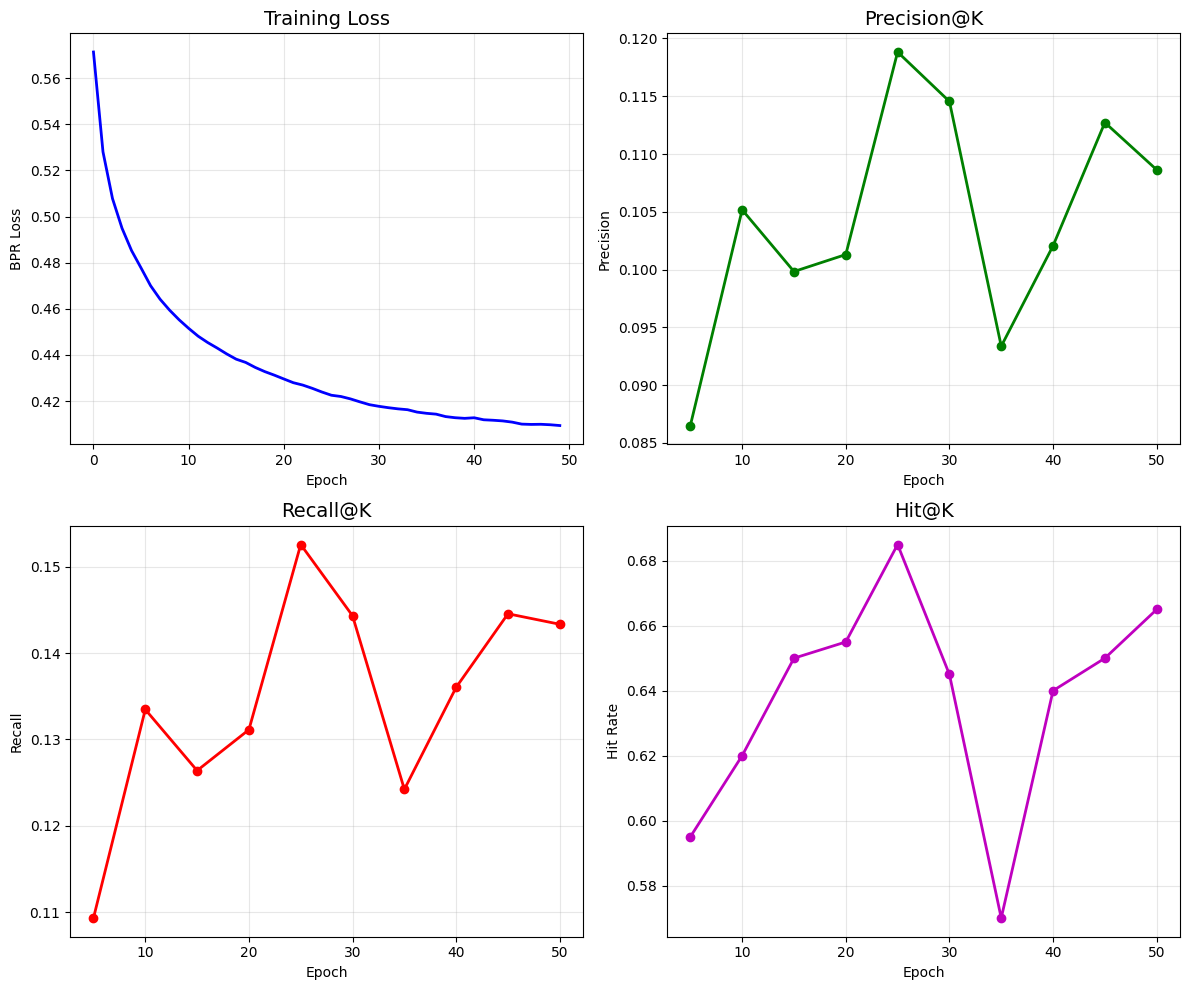

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(history['loss'], 'b-', linewidth=2)
axes[0, 0].set_title('Training Loss', fontsize=14)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('BPR Loss')
axes[0, 0].grid(alpha=0.3)

epochs_val = np.arange(5, EPOCHS+1, 5)[:len(history['precision'])]
axes[0, 1].plot(epochs_val, history['precision'], 'g-o', linewidth=2)
axes[0, 1].set_title('Precision@K', fontsize=14)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(epochs_val, history['recall'], 'r-o', linewidth=2)
axes[1, 0].set_title('Recall@K', fontsize=14)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(epochs_val, history['hit'], 'm-o', linewidth=2)
axes[1, 1].set_title('Hit@K', fontsize=14)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Hit Rate')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../cc_docs/cca2_training.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Validation: AUC-ROC & Threshold Tuning

### Strategy:
1. Calculate AUC-ROC (threshold-independent metric)
2. Find optimal threshold by maximizing F1 score
3. Use this threshold for hybrid recommendation

In [13]:
# Load best model
model.load_state_dict(torch.load('../cc_models/cca2_best.pt'))
model.eval()

with torch.no_grad():
    u_emb, i_emb = model(edge_index, edge_weight)

print("Step 1: Calculating AUC-ROC...")

# Positive samples: validation edges
val_u_gpu = torch.LongTensor(val_df['user_idx'].values).to(device)
val_i_gpu = torch.LongTensor(val_df['item_idx'].values).to(device)
val_pos_scores = (u_emb[val_u_gpu] * i_emb[val_i_gpu]).sum(dim=1).cpu().numpy()

# Negative samples: random pairs not in train/val/test
print("Generating negative samples (excluding all known edges)...")
val_test_edges = set()
for u, i in zip(val_df['user_idx'].values, val_df['item_idx'].values):
    val_test_edges.add((int(u), int(i)))
for u, i in zip(test_df['user_idx'].values, test_df['item_idx'].values):
    val_test_edges.add((int(u), int(i)))

n_neg_samples = len(val_df)
neg_users, neg_items = [], []
sample_count = 0
max_attempts = n_neg_samples * 100
attempts = 0

while sample_count < n_neg_samples and attempts < max_attempts:
    user_idx = np.random.randint(0, n_users)
    item_idx = np.random.randint(0, n_items)
    attempts += 1
    
    if item_idx not in user_train_items[user_idx] and (user_idx, item_idx) not in val_test_edges:
        neg_users.append(user_idx)
        neg_items.append(item_idx)
        sample_count += 1

neg_u_gpu = torch.LongTensor(neg_users).to(device)
neg_i_gpu = torch.LongTensor(neg_items).to(device)
val_neg_scores = (u_emb[neg_u_gpu] * i_emb[neg_i_gpu]).sum(dim=1).cpu().numpy()

# AUC-ROC
all_scores = np.concatenate([val_pos_scores, val_neg_scores])
all_labels = np.concatenate([np.ones(len(val_pos_scores)), np.zeros(len(val_neg_scores))])

val_auc_roc = roc_auc_score(all_labels, all_scores)
print(f"\nValidation AUC-ROC: {val_auc_roc:.4f}")
print(f"  → 1.0 = perfect separation, 0.5 = random")
print(f"\nScore distributions:")
print(f"  Positive scores: mean={val_pos_scores.mean():.4f}, std={val_pos_scores.std():.4f}")
print(f"  Negative scores: mean={val_neg_scores.mean():.4f}, std={val_neg_scores.std():.4f}")

Step 1: Calculating AUC-ROC...
Generating negative samples (excluding all known edges)...

Validation AUC-ROC: 0.8856
  → 1.0 = perfect separation, 0.5 = random

Score distributions:
  Positive scores: mean=1.2507, std=0.7507
  Negative scores: mean=0.1471, std=0.3579


In [14]:
# Step 2: Threshold tuning (F1 maximization)
print("Step 2: Finding optimal threshold for F1 maximization...")

thresholds = np.linspace(all_scores.min(), all_scores.max(), 100)
best_f1, best_th = 0, 0
best_prec, best_rec = 0, 0

results_list = []
for th in thresholds:
    preds = (all_scores > th).astype(int)
    prec = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)
    f1 = f1_score(all_labels, preds, zero_division=0)
    o_ratio = preds.mean()
    
    results_list.append({
        'threshold': th,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'o_ratio': o_ratio
    })
    
    if f1 > best_f1:
        best_f1 = f1
        best_th = th
        best_prec = prec
        best_rec = rec

print(f"\nOptimal Threshold (F1 Maximization):")
print(f"  Threshold: {best_th:.4f}")
print(f"  Precision: {best_prec:.4f}")
print(f"  Recall: {best_rec:.4f}")
print(f"  F1 Score: {best_f1:.4f}")

preds_at_best = (all_scores > best_th).astype(int)
o_ratio_best = preds_at_best.mean()
print(f"  O ratio: {o_ratio_best*100:.1f}%")

OPTIMAL_THRESHOLD = best_th

Step 2: Finding optimal threshold for F1 maximization...

Optimal Threshold (F1 Maximization):
  Threshold: 0.4798
  Precision: 0.8515
  Recall: 0.8300
  F1 Score: 0.8406
  O ratio: 48.7%


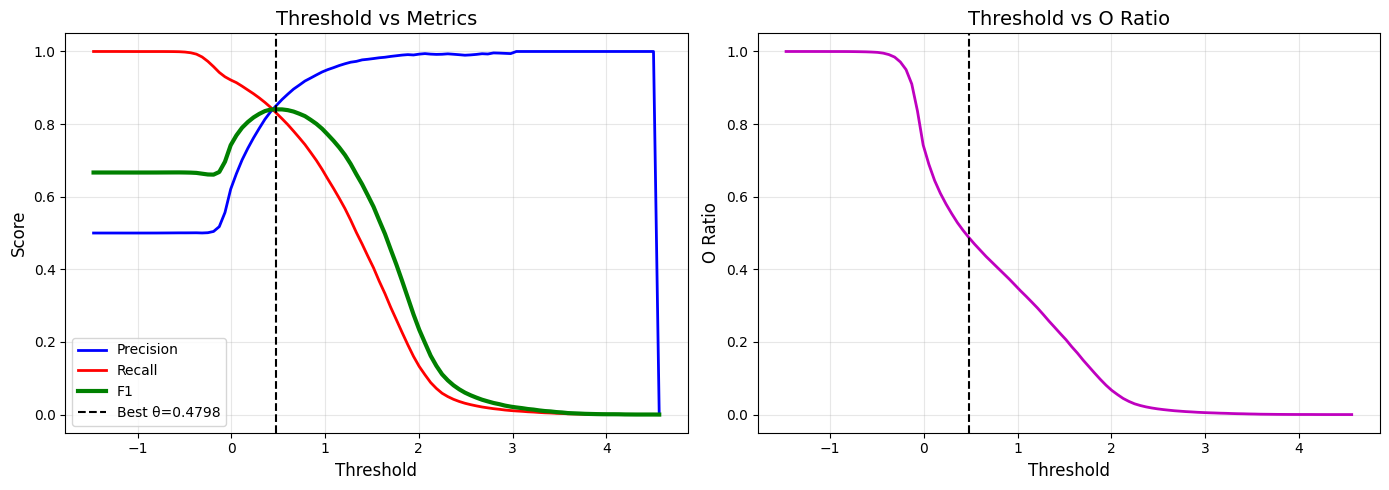


Threshold saved: OPTIMAL_THRESHOLD = 0.4798


In [15]:
# Visualization
results_df = pd.DataFrame(results_list)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(results_df['threshold'], results_df['precision'], 'b-', label='Precision', linewidth=2)
axes[0].plot(results_df['threshold'], results_df['recall'], 'r-', label='Recall', linewidth=2)
axes[0].plot(results_df['threshold'], results_df['f1'], 'g-', label='F1', linewidth=3)
axes[0].axvline(x=best_th, color='k', linestyle='--', label=f'Best θ={best_th:.4f}')
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Threshold vs Metrics', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(results_df['threshold'], results_df['o_ratio'], 'm-', linewidth=2)
axes[1].axvline(x=best_th, color='k', linestyle='--')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('O Ratio', fontsize=12)
axes[1].set_title('Threshold vs O Ratio', fontsize=14)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../cc_docs/cca2_threshold_tuning.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nThreshold saved: OPTIMAL_THRESHOLD = {OPTIMAL_THRESHOLD:.4f}")

## 9. Test Set Evaluation

In [16]:
# Test Top-K evaluation (reference)
test_prec, test_rec, test_hit = evaluate_user_wise_topk(model, test_df, sample_users=500)

print("Test Set Performance (Top-K only) - Reference:")
print(f"  Precision@K: {test_prec:.4f}")
print(f"  Recall@K: {test_rec:.4f}")
print(f"  Hit@K: {test_hit:.4f}")

Test Set Performance (Top-K only) - Reference:
  Precision@K: 0.1375
  Recall@K: 0.1560
  Hit@K: 0.7120


In [17]:
# Test AUC-ROC calculation
print("Calculating Test Set AUC-ROC...")

test_u_gpu = torch.LongTensor(test_df['user_idx'].values).to(device)
test_i_gpu = torch.LongTensor(test_df['item_idx'].values).to(device)
test_pos_scores = (u_emb[test_u_gpu] * i_emb[test_i_gpu]).sum(dim=1).cpu().numpy()

# Test negative samples
n_test_neg = len(test_df)
test_neg_scores = []
for _ in range(n_test_neg):
    user_idx = np.random.randint(0, n_users)
    item_idx = np.random.randint(0, n_items)
    while (item_idx in user_train_items[user_idx] or 
           (user_idx, item_idx) in val_test_edges):
        item_idx = np.random.randint(0, n_items)
    score = (u_emb[user_idx] * i_emb[item_idx]).sum().item()
    test_neg_scores.append(score)

test_neg_scores = np.array(test_neg_scores)

test_all_scores = np.concatenate([test_pos_scores, test_neg_scores])
test_all_labels = np.concatenate([np.ones(len(test_pos_scores)), np.zeros(len(test_neg_scores))])

test_auc_roc = roc_auc_score(test_all_labels, test_all_scores)

print(f"\nTest Set AUC-ROC: {test_auc_roc:.4f}")
print(f"Validation AUC-ROC: {val_auc_roc:.4f}")

# Test metrics with optimal threshold
test_preds = (test_all_scores > OPTIMAL_THRESHOLD).astype(int)
test_acc = (test_preds == test_all_labels).mean()
test_prec_th = precision_score(test_all_labels, test_preds, zero_division=0)
test_rec_th = recall_score(test_all_labels, test_preds, zero_division=0)
test_f1 = f1_score(test_all_labels, test_preds, zero_division=0)
test_o_ratio = test_preds.mean()

print(f"\nTest Set with Threshold={OPTIMAL_THRESHOLD:.4f}:")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_prec_th:.4f}")
print(f"  Recall: {test_rec_th:.4f}")
print(f"  F1 Score: {test_f1:.4f}")
print(f"  O Ratio: {test_o_ratio*100:.1f}%")

Calculating Test Set AUC-ROC...

Test Set AUC-ROC: 0.8905
Validation AUC-ROC: 0.8856

Test Set with Threshold=0.4798:
  Accuracy: 0.8477
  Precision: 0.8541
  Recall: 0.8387
  F1 Score: 0.8463
  O Ratio: 49.1%


## 10. Hybrid Recommendation (Threshold + Top-K)

### Strategy:
1. Filter items with score > threshold
2. Among filtered items, select Top-K
3. K varies by user (20% of interactions, min 2)
4. Satisfies the evaluation rule

In [18]:
def predict_hybrid(test_input_df, threshold, verbose=True):
    """
    Hybrid recommendation: Threshold + Top-K
    1. Score > threshold items only
    2. Among them, select Top-K (0 to K items)
    
    Output format follows AGENTS.md specification:
    ====================
    user   item   recommend
    1      166    O
    4      88     X
    ...
    ====================
    Total recommends = 123/200
    Not recommend = 77/200
    """
    with torch.no_grad():
        u_emb, i_emb = model(edge_index, edge_weight)

    results = []
    stats = {'total_o': 0, 'total_items': 0, 'users_with_o': 0}

    for user in test_input_df['user'].unique():
        if user not in user2idx:
            # Unknown user: all X
            user_rows = test_input_df[test_input_df['user'] == user]
            for _, row in user_rows.iterrows():
                results.append({'user': row['user'], 'item': row['item'], 'recommend': 'X'})
                stats['total_items'] += 1
            continue

        user_idx = user2idx[user]
        user_rows = test_input_df[test_input_df['user'] == user]
        train_items_set = user_train_items[user_idx]

        items_to_score = []
        item_info = []

        for _, row in user_rows.iterrows():
            item = row['item']
            if item not in item2idx:
                results.append({'user': user, 'item': item, 'recommend': 'X'})
                stats['total_items'] += 1
            elif item2idx[item] in train_items_set:
                results.append({'user': user, 'item': item, 'recommend': 'X'})
                stats['total_items'] += 1
            else:
                items_to_score.append(item2idx[item])
                item_info.append(item)

        if len(items_to_score) == 0:
            continue

        # Score items
        item_tensor = torch.LongTensor(items_to_score).to(device)
        user_tensor = torch.full((len(items_to_score),), user_idx, dtype=torch.long, device=device)
        scores = (u_emb[user_tensor] * i_emb[item_tensor]).sum(dim=1).cpu().numpy()

        # Hybrid selection
        above_threshold_mask = scores > threshold
        above_threshold_indices = np.where(above_threshold_mask)[0]

        K = user_k[user_idx]

        if len(above_threshold_indices) > K:
            above_scores = scores[above_threshold_indices]
            top_k_in_above = np.argsort(above_scores)[-K:]
            selected_indices = set(above_threshold_indices[top_k_in_above])
        else:
            selected_indices = set(above_threshold_indices)

        user_o_count = 0
        for i, item in enumerate(item_info):
            if i in selected_indices:
                recommend = 'O'
                user_o_count += 1
            else:
                recommend = 'X'
            results.append({'user': user, 'item': item, 'recommend': recommend})
            stats['total_items'] += 1

        stats['total_o'] += user_o_count
        if user_o_count > 0:
            stats['users_with_o'] += 1

    results_df = pd.DataFrame(results)
    
    # Print in AGENTS.md format
    if verbose:
        print("=" * 50)
        print(f"{'user':<10} {'item':<10} {'recommend':<10}")
        for idx, row in results_df.iterrows():
            print(f"{row['user']:<10} {row['item']:<10} {row['recommend']:<10}")
        print("=" * 50)
        print(f"Total recommends = {stats['total_o']}/{stats['total_items']}")
        print(f"Not recommend = {stats['total_items'] - stats['total_o']}/{stats['total_items']}")
        print()

    return results_df

## 11. Sample Prediction Test

In [19]:
# Test with sample1.csv (has rating column)
sample1 = pd.read_csv('../data/sample1.csv')

print("Sample1.csv Test (A ver expects all O since all have ratings):")
print(f"Threshold: {OPTIMAL_THRESHOLD:.4f}")
print()
predictions1 = predict_hybrid(sample1, OPTIMAL_THRESHOLD, verbose=True)
print(f"Expected for A ver: OOOOO (all interactions are positive)")

Sample1.csv Test (A ver expects all O since all have ratings):
Threshold: 0.4798

user       item       recommend 
109        3745       O         
88         4447       O         
71         4306       O         
66         1747       O         
15         66934      O         
Total recommends = 5/5
Not recommend = 0/5

Expected for A ver: OOOOO (all interactions are positive)


In [20]:
# Test with sample2.csv (no rating column)
sample2 = pd.read_csv('../data/sample2.csv')

print("Sample2.csv Test:")
print(f"Threshold: {OPTIMAL_THRESHOLD:.4f}")
print()
predictions2 = predict_hybrid(sample2, OPTIMAL_THRESHOLD, verbose=True)

Sample2.csv Test:
Threshold: 0.4798

user       item       recommend 
109        3745.0     O         
88         4447.0     O         
71         4306.0     O         
66         1747.0     O         
15         66934.0    O         
Total recommends = 5/5
Not recommend = 0/5



## 12. Final Summary

In [21]:
print("="*70)
print("CCA2")
print("="*70)

print(f"\nModel Config:")
print(f"  Architecture: LightGCN")
print(f"  Embedding dim: {EMB_DIM}")
print(f"  Layers: {N_LAYERS}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nStrategy:")
print(f"  Ground Truth: All interactions (rating ignored)")
print(f"  Graph: Unweighted bipartite")
print(f"  Negative Sampling: Hard ({HARD_NEG_RATIO:.0%}) + Random ({1-HARD_NEG_RATIO:.0%})")
print(f"  Loss: BPR Loss")

print(f"\nData:")
print(f"  Total edges: {len(df):,}")
print(f"  Train: {len(train_df):,}")
print(f"  Val: {len(val_df):,}")
print(f"  Test: {len(test_df):,}")

print(f"\nOptimal Threshold (F1 Maximization):")
print(f"  Threshold: {OPTIMAL_THRESHOLD:.4f}")

print(f"\nTest Performance:")
print(f"  AUC-ROC: {test_auc_roc:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_prec_th:.4f}")
print(f"  Recall: {test_rec_th:.4f}")
print(f"  F1 Score: {test_f1:.4f}")

print(f"\nModel saved to: ../cc_models/cca2_best.pt")
print(f"Threshold for inference: {OPTIMAL_THRESHOLD:.4f}")
print("\nReady for final test set prediction!")

CCA2

Model Config:
  Architecture: LightGCN
  Embedding dim: 32
  Layers: 2
  Parameters: 351,648

Strategy:
  Ground Truth: All interactions (rating ignored)
  Graph: Unweighted bipartite
  Negative Sampling: Hard (50%) + Random (50%)
  Loss: BPR Loss

Data:
  Total edges: 105,139
  Train: 73,293
  Val: 15,479
  Test: 16,367

Optimal Threshold (F1 Maximization):
  Threshold: 0.4798

Test Performance:
  AUC-ROC: 0.8905
  Accuracy: 0.8477
  Precision: 0.8541
  Recall: 0.8387
  F1 Score: 0.8463

Model saved to: ../cc_models/cca2_best.pt
Threshold for inference: 0.4798

Ready for final test set prediction!


## 13. Final Test Inference (Uncomment when ready)

```python
# When professor provides test.csv:
final_test = pd.read_csv('../data/test.csv')
print(f"Using threshold: {OPTIMAL_THRESHOLD:.4f}")
final_predictions = predict_hybrid(final_test, OPTIMAL_THRESHOLD)
final_predictions.to_csv('../cc/cca2_predictions.csv', index=False)
print(f"\nPredictions saved to ../cc/cca2_predictions.csv")
```